In [3]:
# ======================================================
# STEP 6 — TRAINING + VALIDATION ONLY (NO TEST SET)
# ======================================================

import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score
)

# ======================================================
# 1️⃣ PATH
# ======================================================

TRAIN_PATH = "/Users/marcodonatiello/PycharmProjects/JupyterProject/data/interim/splits/train_step5.csv"
VAL_PATH   = "/Users/marcodonatiello/PycharmProjects/JupyterProject/data/interim/splits/val_step5.csv"

# ======================================================
# 2️⃣ LOAD DATASET
# ======================================================

train = pd.read_csv(TRAIN_PATH)
val   = pd.read_csv(VAL_PATH)

print("Train shape:", train.shape)
print("Val shape:", val.shape)

# ======================================================
# 3️⃣ SPLIT X / y
# ======================================================

TARGET = "IS_SEVERE"

X_train = train.drop(columns=[TARGET])
y_train = train[TARGET]

X_val = val.drop(columns=[TARGET])
y_val = val[TARGET]

print("\nTarget distribution (train):")
print(y_train.value_counts(normalize=True))

print("\nTarget distribution (val):")
print(y_val.value_counts(normalize=True))

# ======================================================
# 4️⃣ MODELLO (CLASS WEIGHT)
# ======================================================

model = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    min_samples_leaf=5,
    n_jobs=-1,
    random_state=42,
    class_weight="balanced"
)

model.fit(X_train, y_train)

print("\n✅ Modello addestrato con class_weight")

# ======================================================
# 5️⃣ PREDIZIONE SU VALIDATION (SOGLIA REGOLABILE)
# ======================================================

THRESHOLD = 0.35   # ← cambia QUI se vuoi più/meno recall

val_probs = model.predict_proba(X_val)[:, 1]
val_pred  = (val_probs >= THRESHOLD).astype(int)

# ======================================================
# 6️⃣ METRICHE (VALIDATION)
# ======================================================

print("\n📊 CLASSIFICATION REPORT (VALIDATION)")
print(classification_report(y_val, val_pred, digits=4))

print("📉 CONFUSION MATRIX")
print(confusion_matrix(y_val, val_pred))

print("\n🎯 CLASSE SEVERA (1)")
print("Recall    :", recall_score(y_val, val_pred))
print("Precision :", precision_score(y_val, val_pred))
print("F1-score  :", f1_score(y_val, val_pred))

# ======================================================
# 7️⃣ INFO FINALI
# ======================================================

false_negatives = ((y_val == 1) & (val_pred == 0)).sum()
false_positives = ((y_val == 0) & (val_pred == 1)).sum()

print("\n❗ Errori critici")
print("False Negatives (severi persi):", false_negatives)
print("False Positives:", false_positives)

print("\n✅ VALIDATION COMPLETATA — TEST SET NON TOCCATO")


Train shape: (536370, 78)
Val shape: (134093, 78)

Target distribution (train):
IS_SEVERE
0    0.871577
1    0.128423
Name: proportion, dtype: float64

Target distribution (val):
IS_SEVERE
0    0.871574
1    0.128426
Name: proportion, dtype: float64

✅ Modello addestrato con class_weight

📊 CLASSIFICATION REPORT (VALIDATION)
              precision    recall  f1-score   support

           0     0.9792    0.7356    0.8401    116872
           1     0.3326    0.8942    0.4848     17221

    accuracy                         0.7560    134093
   macro avg     0.6559    0.8149    0.6625    134093
weighted avg     0.8962    0.7560    0.7945    134093

📉 CONFUSION MATRIX
[[85971 30901]
 [ 1822 15399]]

🎯 CLASSE SEVERA (1)
Recall    : 0.8941989431508043
Precision : 0.33259179265658745
F1-score  : 0.48484753073786624

❗ Errori critici
False Negatives (severi persi): 1822
False Positives: 30901

✅ VALIDATION COMPLETATA — TEST SET NON TOCCATO


In [4]:
# ======================================================
# MODEL TRAINING & SELECTION — FINAL PIPELINE
# ======================================================

import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    recall_score,
    precision_score,
    f1_score,
    make_scorer
)

# ======================================================
# 1️⃣ PATH
# ======================================================

TRAIN_PATH = "/Users/marcodonatiello/PycharmProjects/JupyterProject/data/interim/splits/train_step5.csv"
VAL_PATH   = "/Users/marcodonatiello/PycharmProjects/JupyterProject/data/interim/splits/val_step5.csv"

TARGET = "IS_SEVERE"

# ======================================================
# 2️⃣ LOAD DATA
# ======================================================

train = pd.read_csv(TRAIN_PATH)
val   = pd.read_csv(VAL_PATH)

print("Train shape:", train.shape)
print("Val shape:", val.shape)

# ======================================================
# 3️⃣ SPLIT FEATURES / TARGET
# ======================================================

X_train = train.drop(columns=[TARGET])
y_train = train[TARGET]

X_val = val.drop(columns=[TARGET])
y_val = val[TARGET]

print("\nTarget distribution (train):")
print(y_train.value_counts(normalize=True))

print("\nTarget distribution (val):")
print(y_val.value_counts(normalize=True))

# ======================================================
# 4️⃣ SCORER — PRIORITÀ CLASSE SEVERA
# ======================================================

recall_severe = make_scorer(recall_score, pos_label=1)

# ======================================================
# 5️⃣ MODELLO BASE
# ======================================================

rf = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"
)

# ======================================================
# 6️⃣ GRID IPERPARAMETRI
# ======================================================

param_grid = {
    "n_estimators": [200, 300],
    "max_depth": [15, 20, None],
    "min_samples_leaf": [3, 5, 10]
}

# ======================================================
# 7️⃣ CROSS-VALIDATION (SOLO TRAIN)
# ======================================================

cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring=recall_severe,
    cv=cv,
    n_jobs=-1,
    verbose=2
)

print("\n🚀 Avvio Cross-Validation...")
grid.fit(X_train, y_train)

print("\n🏆 MIGLIORI IPERPARAMETRI")
print(grid.best_params_)
print("🎯 Miglior Recall CV (classe severa):", grid.best_score_)

# ======================================================
# 8️⃣ TRAIN FINALE SU TUTTO IL TRAIN
# ======================================================

best_model = grid.best_estimator_
best_model.fit(X_train, y_train)

print("\n✅ Modello finale addestrato su TUTTO il train")

# ======================================================
# 9️⃣ VALIDATION (SOGLIA DECISIONALE)
# ======================================================

THRESHOLD = 0.35  # ← regolabile

val_probs = best_model.predict_proba(X_val)[:, 1]
val_pred  = (val_probs >= THRESHOLD).astype(int)

# ======================================================
# 🔟 METRICHE FINALI
# ======================================================

print("\n📊 CLASSIFICATION REPORT (VALIDATION)")
print(classification_report(y_val, val_pred, digits=4))

print("📉 CONFUSION MATRIX")
print(confusion_matrix(y_val, val_pred))

print("\n🎯 CLASSE SEVERA (1)")
print("Recall    :", recall_score(y_val, val_pred))
print("Precision :", precision_score(y_val, val_pred))
print("F1-score  :", f1_score(y_val, val_pred))

false_negatives = ((y_val == 1) & (val_pred == 0)).sum()
false_positives = ((y_val == 0) & (val_pred == 1)).sum()

print("\n❗ Errori critici")
print("False Negatives:", false_negatives)
print("False Positives:", false_positives)

print("\n🔒 PIPELINE CORRETTA — TEST SET NON UTILIZZATO")


Train shape: (536370, 78)
Val shape: (134093, 78)

Target distribution (train):
IS_SEVERE
0    0.871577
1    0.128423
Name: proportion, dtype: float64

Target distribution (val):
IS_SEVERE
0    0.871574
1    0.128426
Name: proportion, dtype: float64

🚀 Avvio Cross-Validation...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END .max_depth=15, min_samples_leaf=3, n_estimators=200; total time= 1.7min
[CV] END .max_depth=15, min_samples_leaf=3, n_estimators=200; total time= 1.7min
[CV] END .max_depth=15, min_samples_leaf=3, n_estimators=200; total time= 1.8min
[CV] END .max_depth=15, min_samples_leaf=3, n_estimators=200; total time= 1.8min
[CV] END .max_depth=15, min_samples_leaf=3, n_estimators=200; total time= 1.8min
[CV] END .max_depth=15, min_samples_leaf=3, n_estimators=300; total time= 2.6min
[CV] END .max_depth=15, min_samples_leaf=3, n_estimators=300; total time= 2.6min
[CV] END .max_depth=15, min_samples_leaf=3, n_estimators=300; total time= 2.6min
[CV] END .ma

/Users/marcodonatiello/PycharmProjects/JupyterProject/.venv/lib/python3.14/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/marcodonatiello/PycharmProjects/JupyterProject/.venv/lib/python3.14/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/marcodonatiello/PycharmProjects/JupyterProject/.venv/lib/python3.14/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to

[CV] END max_depth=None, min_samples_leaf=5, n_estimators=300; total time= 4.3min


/Users/marcodonatiello/PycharmProjects/JupyterProject/.venv/lib/python3.14/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/marcodonatiello/PycharmProjects/JupyterProject/.venv/lib/python3.14/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/marcodonatiello/PycharmProjects/JupyterProject/.venv/lib/python3.14/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to

[CV] END max_depth=None, min_samples_leaf=5, n_estimators=300; total time= 4.4min


/Users/marcodonatiello/PycharmProjects/JupyterProject/.venv/lib/python3.14/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/marcodonatiello/PycharmProjects/JupyterProject/.venv/lib/python3.14/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/marcodonatiello/PycharmProjects/JupyterProject/.venv/lib/python3.14/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to

[CV] END max_depth=None, min_samples_leaf=10, n_estimators=200; total time= 2.9min


/Users/marcodonatiello/PycharmProjects/JupyterProject/.venv/lib/python3.14/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/marcodonatiello/PycharmProjects/JupyterProject/.venv/lib/python3.14/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/marcodonatiello/PycharmProjects/JupyterProject/.venv/lib/python3.14/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to

[CV] END max_depth=None, min_samples_leaf=10, n_estimators=200; total time= 2.8min


/Users/marcodonatiello/PycharmProjects/JupyterProject/.venv/lib/python3.14/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/marcodonatiello/PycharmProjects/JupyterProject/.venv/lib/python3.14/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/marcodonatiello/PycharmProjects/JupyterProject/.venv/lib/python3.14/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to

[CV] END max_depth=None, min_samples_leaf=5, n_estimators=300; total time= 4.3min
[CV] END max_depth=None, min_samples_leaf=5, n_estimators=300; total time= 4.4min
[CV] END max_depth=None, min_samples_leaf=10, n_estimators=300; total time= 2.1min
[CV] END max_depth=None, min_samples_leaf=10, n_estimators=300; total time= 2.1min
[CV] END max_depth=None, min_samples_leaf=10, n_estimators=300; total time= 2.1min
[CV] END max_depth=None, min_samples_leaf=10, n_estimators=300; total time= 2.1min
[CV] END max_depth=None, min_samples_leaf=10, n_estimators=300; total time= 2.1min

🏆 MIGLIORI IPERPARAMETRI
{'max_depth': 15, 'min_samples_leaf': 10, 'n_estimators': 300}
🎯 Miglior Recall CV (classe severa): 0.8226387376004226

✅ Modello finale addestrato su TUTTO il train

📊 CLASSIFICATION REPORT (VALIDATION)
              precision    recall  f1-score   support

           0     0.9807    0.7120    0.8250    116872
           1     0.3165    0.9051    0.4690     17221

    accuracy               

⏳ Caricamento dati...
⚙️ Addestramento modello in corso...
📊 Generazione grafico...


/var/folders/jl/j7psshq11xl001nmt4fr5dcc0000gn/T/ipykernel_6252/56603882.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_imp_df.head(20), palette='viridis')


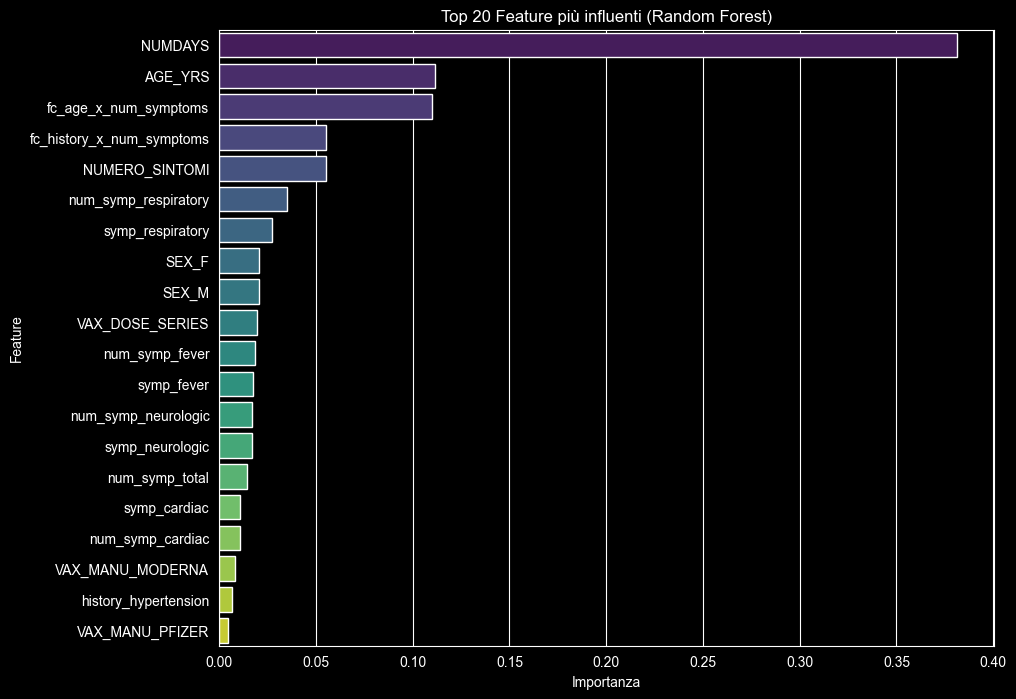


🏆 LE 10 VARIABILI PIÙ IMPORTANTI:
                  Feature  Importance
                  NUMDAYS    0.381422
                  AGE_YRS    0.111671
    fc_age_x_num_symptoms    0.110088
fc_history_x_num_symptoms    0.055416
           NUMERO_SINTOMI    0.055279
     num_symp_respiratory    0.035222
         symp_respiratory    0.027380
                    SEX_F    0.020712
                    SEX_M    0.020576
          VAX_DOSE_SERIES    0.019680


In [5]:
# ======================================================
# SOLUZIONE COMPLETA: CARICAMENTO + TRAIN + GRAFICO
# ======================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import recall_score, make_scorer

# 1️⃣ PATH (Verifica che siano corretti!)
TRAIN_PATH = "/Users/marcodonatiello/PycharmProjects/JupyterProject/data/interim/splits/train_step5.csv"
VAL_PATH   = "/Users/marcodonatiello/PycharmProjects/JupyterProject/data/interim/splits/val_step5.csv"
TARGET = "IS_SEVERE"

# 2️⃣ LOAD & SPLIT
print("⏳ Caricamento dati...")
train = pd.read_csv(TRAIN_PATH)
X_train = train.drop(columns=[TARGET])
y_train = train[TARGET]

# 3️⃣ TRAIN (Versione ottimizzata veloce per il grafico)
print("⚙️ Addestramento modello in corso...")
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"
)
rf.fit(X_train, y_train) # Addestriamo direttamente (senza GridSearch per velocità)

# 4️⃣ FEATURE IMPORTANCE
print("📊 Generazione grafico...")
feature_names = X_train.columns
importances = rf.feature_importances_

feature_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# 5️⃣ GRAFICO
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_imp_df.head(20), palette='viridis')
plt.title('Top 20 Feature più influenti (Random Forest)')
plt.xlabel('Importanza')
plt.ylabel('Feature')
plt.show()

print("\n🏆 LE 10 VARIABILI PIÙ IMPORTANTI:")
print(feature_imp_df.head(10).to_string(index=False))

Format rilevato: MATRICE 3D (Nuovo Standard)

📊 GRAFICO SHAP BEESWARM
Come leggere il grafico:
- Punti ROSSI: Valore alto della variabile
- Punti BLU: Valore basso della variabile
- Verso DESTRA (asse X > 0): Aumenta il rischio Severo
- Verso SINISTRA (asse X < 0): Protegge (Non Severo)


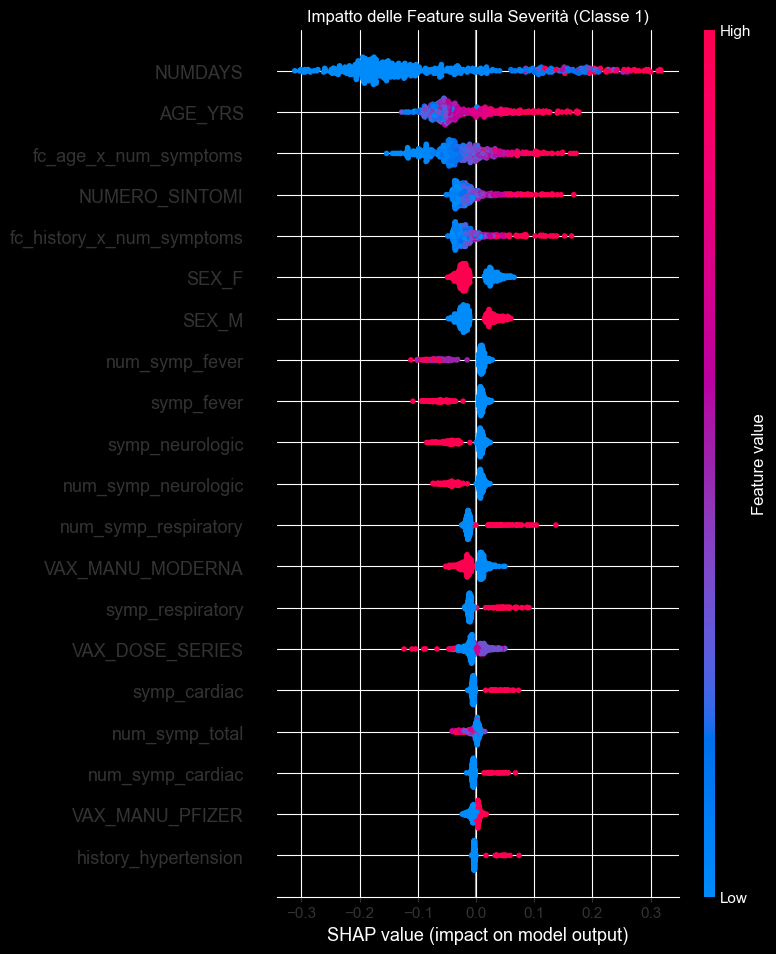

In [7]:
# ======================================================
# 1️⃣2️⃣ ANALISI SHAP (FIX COMPATIBILITÀ)
# ======================================================
import shap
import matplotlib.pyplot as plt
import numpy as np

# 1. Inizializza l'explainer
explainer = shap.TreeExplainer(rf)

# 2. Calcola SHAP su un campione
X_sample = X_train.sample(n=500, random_state=42)
shap_values = explainer.shap_values(X_sample)

# --- BLOCCO DI CORREZIONE FORMATO ---
# Questo pezzo capisce se shap ci ha dato una Lista o una Matrice 3D
vals_to_plot = None

if isinstance(shap_values, list):
    # CASO A: Vecchio standard (Lista di matrici)
    print("Format rilevato: LISTA (Standard Classico)")
    vals_to_plot = shap_values[1] # Indice 1 = Classe 'Severe'

elif len(np.shape(shap_values)) == 3:
    # CASO B: Nuovo standard (Matrice 3D: righe, colonne, classi)
    print("Format rilevato: MATRICE 3D (Nuovo Standard)")
    # Selezioniamo tutte le righe, tutte le colonne, ma solo l'indice 1 della terza dimensione
    vals_to_plot = shap_values[:, :, 1]

else:
    # CASO C: Regressione o binario appiattito
    print("Format rilevato: MATRICE 2D")
    vals_to_plot = shap_values

# ------------------------------------

print("\n📊 GRAFICO SHAP BEESWARM")
print("Come leggere il grafico:")
print("- Punti ROSSI: Valore alto della variabile")
print("- Punti BLU: Valore basso della variabile")
print("- Verso DESTRA (asse X > 0): Aumenta il rischio Severo")
print("- Verso SINISTRA (asse X < 0): Protegge (Non Severo)")

plt.figure(figsize=(10, 8))
shap.summary_plot(vals_to_plot, X_sample, show=False)
plt.title("Impatto delle Feature sulla Severità (Classe 1)")
plt.show()
